In [1]:
#!pip install hypernetx

In [2]:
#!pip install networkx

<img src='images/harrypotter_image.png' width='200px' style="float:left;margin-right:10pt"></img>
# Illustration of Static Hypergraphs using Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. 

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in the `hypernetx/utils/toys directory`.

In [3]:
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt


## The Harry Potter Dataset: 
To use a csv file for a Static Hypergraph, we need every cell filled with a label. 
We have edited the Harry Potter dataset so that it has 5 categories and every cell is filled. Where a value is unknown, we marked it as "Unknown *category_name*". 

In [4]:
hogwarts = hnx.HarryPotter()

In [5]:
hogwarts.dataframe

,House,Blood status,Species,Hair colour,Eye colour
0,Gryffindor,Half-blood,Human,Black,Bright green
1,Gryffindor,Pure-blood,Human,Red,Blue
2,Gryffindor,Muggle-born,Human,Brown,Brown
3,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
4,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
135,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
136,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
137,Unknown House,Pure-blood or half-blood,Human,Blond,Blue
138,Unknown House,Unknown Blood status,Elf,Unknown Hair colour,Unknown Eye colour


### We define a labeling based on the categories and store it in an Ordered Dictionary.
The ordering of labels is determined by their order of appearance in the table with the exception of Unknown labels, which are always listed first.

In [6]:
hogwarts.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25')),
             ('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
 

### Assign unique ids to the label values 
We encode the data in each column of the dataframe using a sequence of integers and store the coded data along with a translator function to retrieve the original names as needed. Here we remove duplicate rows but counts could be collected for a weighting scheme. **Watch for a near future release.**

In [7]:
## List of nonzero indices
hogwarts.data

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  3],
       [ 0,  0,  1,  1,  4],
       [ 0,  0,  1,  2,  3],
       [ 0,  0,  1, 19,  0],
       [ 0,  0,  1, 19, 25],
       [ 0,  0,  1, 26, 18],
       [ 0,  0,  3, 19,  0],
       [ 0,  0,  6, 20,  4],
       [ 0,  0,  7, 16, 15],
       [ 0,  0,  9,  0,  0],
       [ 0,  1,  1, 19, 22],
       [ 0,  1,  1, 29,  3],
       [ 0,  2,  1,  2,  7],
       [ 0,  2,  1, 15,  0],
       [ 0,  2,  1, 18,  4],
       [ 0,  2,  1, 19,  0],
       [ 0,  2,  1, 19, 17],
       [ 0,  2,  1, 27, 20],
       [ 0,  2,  1, 31, 23],
       [ 0,  5,  1,  0,  0],
       [ 0,  5,  1,  1,  0],
       [ 0,  5,  1,  3, 19],
       [ 0,  5,  1,  5,  2],
       [ 0,  5,  1, 10,  9],
       [ 0,  5,  1, 15,  0],
       [ 0,  5,  1, 19,  0],
       [ 0,  5,  1, 21, 14],
       [ 0,  5,  1, 25,  0],
       [ 0,  5,  1, 30,  3],
       [ 0,  9,  1,  1,  0],
       [ 0,  9,  1,  5,  2],
       [ 0,  9

In [8]:
hogwarts.data.shape

(126, 5)

## StaticEntity and StaticEntitySet

The entire dataset has now been represented using a data array and a dictionary associating columns and integers with labels and values in the original data.

The basic object in HyperNetX, which holds the data and label dictionary for a static hypergraph, is a `StaticEntity`. Similar to the `hnx.Entity` class, the data structure rests in the background to hold the data for flexibly switching between different orders of containment.

Each column of the data is considered a **level** in the StaticEntity. A level's order corresponds to its column position in the datatable. The column header serves as a key to the label dictionary.

In [9]:
E = hnx.StaticEntity(data = hogwarts.data, labels = hogwarts.labels)
E.keys

array(['House', 'Blood status', 'Species', 'Hair colour', 'Eye colour'],
      dtype='<U12')

### A StaticEntitySet is a StaticEntity restricted to two levels. 
By default, a StaticEntity will grab the 1st two levels of the data and first two keys of the labels, but any pair of levels may be specified. 

In [10]:
ES = hnx.StaticEntitySet(E)
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

## Static Hypergraph
A static hypergraph is one where all nodes and edges are known at the time of construction. This permits an internal ordering and uid structure for easy reference and faster computation of metrics.

**Static Hypegraphs can be instantiated with a StaticEntitySet similar to the way a dynamic hypergrapah can be instantiated using an EntitySet.**




In [11]:
H = hnx.Hypergraph(ES,static=True,name='Hogwarts')


**But we can also pass the dataframe and specify which columns we want to use as edges and nodes. The default behavior is to use the first two columns.**
$$\text{df}[\text{edge_column},\text{node_column}]$$

In [12]:
H = hnx.Hypergraph(hogwarts.dataframe)
H.edges,H.nodes

(StaticEntitySet(None,['Ravenclaw', 'Hufflepuff', 'Beauxbatons Academy of Magic', 'Unknown House', 'Gryffindor', 'Slytherin', 'Durmstrang Institute'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])}),
 StaticEntitySet(None,['Pure-blood', 'Half-blood', 'Squib', 'Muggle-born or half-blood', 'Part-Goblin', 'Pure-blood or half-blood', 'Quarter-Veela', 'Muggle-born', 'Muggle', 'Unknown Blood status', 'Part-Human'],{}))

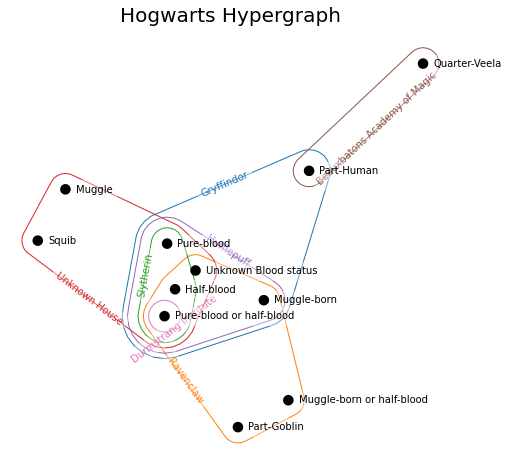

In [13]:
plt.title('Hogwarts Hypergraph',fontsize=20)
hnx.draw(H)

## General construction of a static Hypergraph:
Set the parameter `static=True` inside the hypergraph constructor and input a set system just as you did before. If the set system is a pandas dataframe, a StaticEntity or a StaticEntitySet, the parameter is automaticaly set to True.

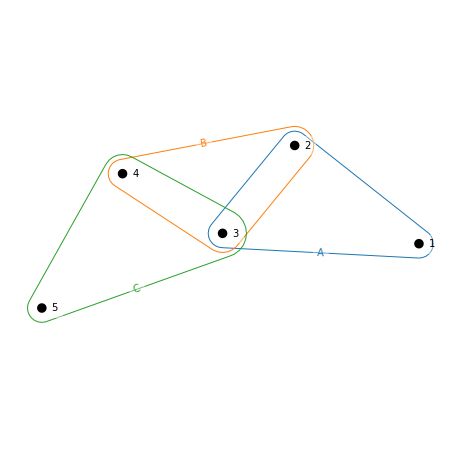

In [14]:
## example:
simple_data = {'A':{1,2,3},'B':{2,3,4},'C':{3,4,5}}
simple_static_hypergraph = SSH = hnx.Hypergraph(simple_data, static=True)
hnx.draw(SSH)

In [15]:
SSH.isstatic

True

#### Static Hypergraphs are immutable. You can't add or remove nodes or edges. Uncomment the last line below and try it:


In [16]:
## Static Hypergraphs are immutable. You can't add or remove nodes or edges.
## Uncomment the last line and try it:
new_edge = hnx.Entity('D',[4,5,6])
# SSH.add_edge(new_edge)

In [17]:
## But you can remove the static property and create a new hypergraph 
## This will also remove the benefits of an immutable datastructure and may slow things down.
SSH = SSH.remove_static()
SSH.add_edge(new_edge)

Hypergraph({'A': Entity(A,[1, 2, 3],{}), 'B': Entity(B,[2, 3, 4],{}), 'C': Entity(C,[3, 4, 5],{}), 'D': Entity(D,[4, 5, 6],{})},name=)

## State Dictionary
Since a static hypergraph does not lose nodes and edges, metrics computed on the hypergraph will persist. We store them in a state dictionary. 

Let $H$ be the Hogwarts hypergraph we constructed above.

In [18]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
          4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {}}

### The output of certain methods are automatically stored in the state dictionary once they are computed.

In [19]:
H.incidence_matrix().todense()
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
          4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {},
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>}

### They can be retrieved by their keys. But will automatically be retrieved when the method is called again to avoid duplicating the computation.

In [20]:
H.state_dict['incidence_matrix'].todense()

matrix([[1, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]])

## Most Hypergraph methods apply to Static Hypergraphs
Any method, which does not change the data and labels of the underlying StaticEntitySet, can be used by the static Hypergraph.

In [21]:
H.dataframe()

,Gryffindor,Ravenclaw,Slytherin,Unknown House,Hufflepuff,Beauxbatons Academy of Magic,Durmstrang Institute
Half-blood,1,1,1,1,1,0,0
Pure-blood,1,0,1,1,1,0,0
Muggle-born,1,1,0,0,1,0,0
Part-Human,1,0,0,0,0,1,0
Pure-blood or half-blood,1,1,1,1,1,0,1
Unknown Blood status,1,1,0,1,1,0,0
Part-Goblin,0,1,0,0,0,0,0
Muggle-born or half-blood,0,1,0,0,0,0,0
Quarter-Veela,0,0,0,0,0,1,0
Muggle,0,0,0,1,0,0,0


### Restrict to specific edges and nodes

In [22]:
HF = H.restrict_to_edges(['Gryffindor','Ravenclaw','Slytherin','Hufflepuff'])
HF.dataframe()

,Gryffindor,Ravenclaw,Slytherin,Hufflepuff
Half-blood,1,1,1,1
Pure-blood,1,0,1,1
Muggle-born,1,1,0,1
Part-Human,1,0,0,0
Pure-blood or half-blood,1,1,1,1
Unknown Blood status,1,1,0,1
Part-Goblin,0,1,0,0
Muggle-born or half-blood,0,1,0,0


StaticEntitySet(None,['Ravenclaw', 'Hufflepuff', 'Beauxbatons Academy of Magic', 'Unknown House', 'Gryffindor', 'Slytherin', 'Durmstrang Institute'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])})

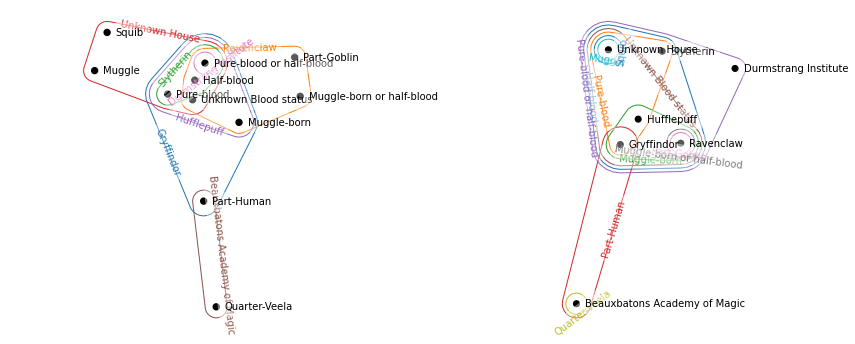

In [23]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
hnx.draw(H,ax=ax[0]);
hnx.draw(H.dual())
H.edges

## Collapse identical elements
This method exists to collapse identical nodes and edges and is implemented for dynamic hypergraphs.
We wish to do the same for large unwieldy hypergraphs stored as static.

In [24]:
pos = {'Unknown House': [-0.11,  0.4 ],
 'Gryffindor': [-0.32,  0.27],
 'Ravenclaw': [0.57, 0.27],
 'Hufflepuff': [-0.02,  0.16],
 'Slytherin': [-0.02, -0.51],
 'Durmstrang Institute': [-0.09, -1.  ],
 'Unknown Blood status': [0.15, 0.66],
 'Half-blood': [0.24, 0.04],
 'Pure-blood': [-0.45, -0.08],
 'Pure-blood or half-blood': [ 0.05, -0.21]}

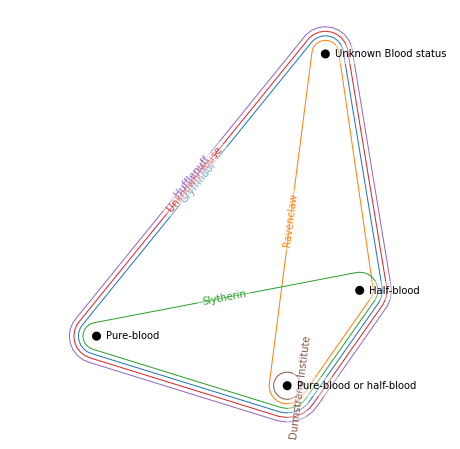

In [25]:
nodes = ['Pure-blood or half-blood',  'Unknown Blood status', 'Pure-blood', 'Half-blood',  ]
Hn = H.restrict_to_nodes(nodes)
hnx.draw(Hn,pos=pos)

OrderedDict([('Gryffindor:3', ['Gryffindor', 'Unknown House', 'Hufflepuff']),
             ('Ravenclaw:1', ['Ravenclaw']),
             ('Slytherin:1', ['Slytherin']),
             ('Durmstrang Institute:1', ['Durmstrang Institute'])])

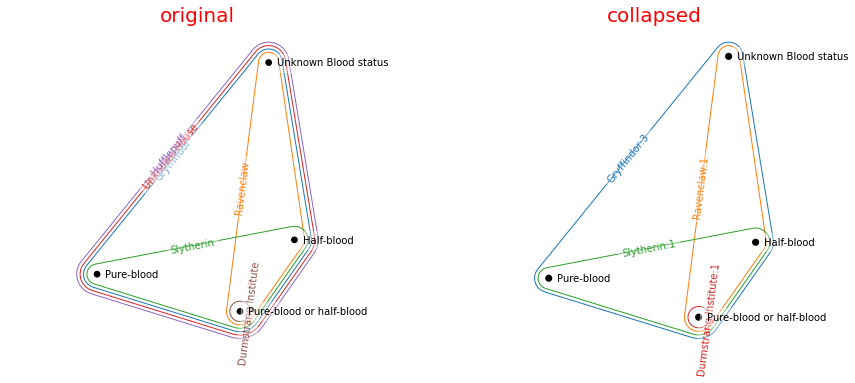

In [26]:
Hc,clses = Hn.collapse_edges(return_equivalence_classes=True)

fig,ax = plt.subplots(1,2,figsize=(15,6))
hnx.draw(Hn,ax=ax[0],pos=pos);
ax[0].set_title('original',fontsize=20,color='r')
hnx.draw(Hc,ax=ax[1],pos=pos);
ax[1].set_title('collapsed',fontsize=20,color='r');
clses

### More hypergraph methods

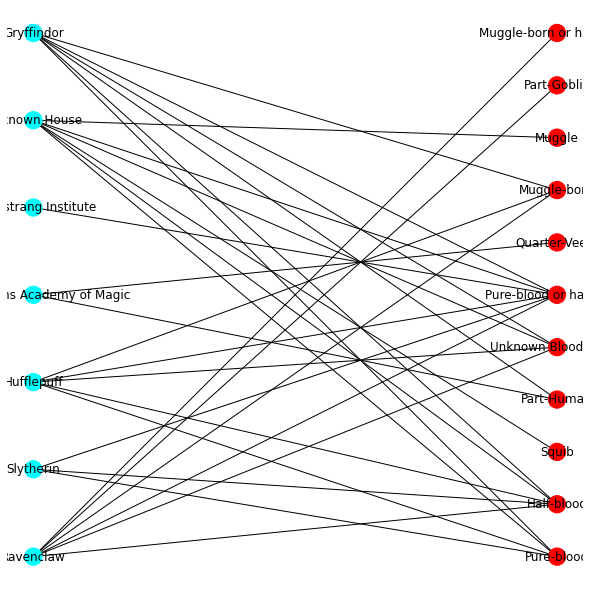

In [27]:
## bipartite
G = H.bipartite() ## this is a NetworkX graph
cmap = ['r' if G.nodes[n]['bipartite']==0 else 'cyan' for n in G.nodes ]
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw(H.bipartite(),node_color=cmap,with_labels=True, pos=pos)

In [28]:
## reporting
print(hnx.info(H))

Number of Rows: 11
Number of Columns: 7
Aspect Ratio: 1.5714285714285714
Number of non-empty Cells: 29
Density: 0.37662337662337664


In [29]:
## Once the dist stats are computed, they are stored in the state dict for fast recall and reference
hnx.dist_stats(H)

{'nrows': 11,
 'ncols': 7,
 'aspect ratio': 1.5714285714285714,
 'ncells': 29,
 'density': 0.37662337662337664,
 'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
 'node degree centrality stats': {'min': 1,
  'max': 6,
  'mean': 2.6363636363636362,
  'median': 2.0,
  'std': 1.7721444263289026},
 'node degree hist': Counter({6: 1, 5: 1, 4: 2, 3: 1, 2: 1, 1: 5}),
 'max node degree': 6,
 'edge size list': [6, 6, 6, 5, 3, 2, 1],
 'edge size centrality stats': {'min': 1,
  'max': 6,
  'mean': 4.142857142857143,
  'median': 5.0,
  'std': 1.9587584572574412},
 'edge size hist': Counter({6: 3, 5: 1, 3: 1, 2: 1, 1: 1}),
 'max edge size': 6,
 'comp nodes list': [11],
 'comp nodes hist': Counter({11: 1}),
 'comp nodes centrality stats': {'min': 11,
  'max': 11,
  'mean': 11.0,
  'median': 11.0,
  'std': 0.0},
 'comp edges list': [7],
 'comp edges hist': Counter({7: 1}),
 'comp edges centrality stats': {'min': 7,
  'max': 7,
  'mean': 7.0,
  'median': 7.0,
  'std': 0.0},
 'num comps': 1}

In [30]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  3,  4,  5,  0,  2,  4,  5,  6,  7,  0,  1,  4,  0,  1,
          4,  5,  9, 10,  0,  1,  2,  4,  5,  3,  8,  4]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {1: <networkx.classes.graph.Graph at 0x7f841144f050>},
 'sedgelg': {1: <networkx.classes.graph.Graph at 0x7f8411457050>},
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 'edge_size_dist': [6, 6, 3, 6, 5, 2, 1],
 'dist_stats': {'nrows': 11,
  'ncols': 7,
  'aspect ratio': 1.5714285714285714,
  'ncells': 29,
  'density': 0.37662337662337664,
  'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
  'node degree centrality stats': {'min': 1,
   'max': 6,
   'mean': 2.6363636363636362,
   'median': 2.0,
   'std': 1.7721444263289026},
  'nod

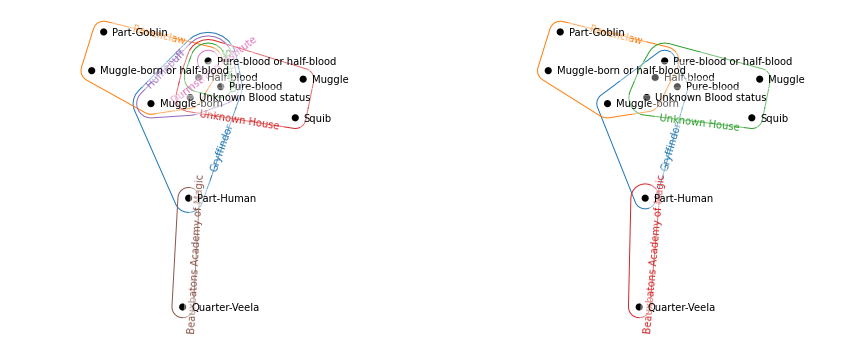

In [31]:
## toplexes
fig,ax = plt.subplots(1,2,figsize=(15,6))
pos = hnx.draw(H,ax=ax[0],return_pos=True)
hnx.draw(H.toplexes(),ax=ax[1],pos=pos)